# Transfer learning / fine-tuning




In [1]:
!pip install hyperas

In [2]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation,GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [3]:
import time

In [4]:
import numpy as np
from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from hyperas import optim
from hyperas.distributions import choice, uniform

## getting dataset.

In [5]:
!rm -r -f muestras muestras.rar
# !wget https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras.rar
# !wget -O muestras.rar https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras_C14.rar
# !wget -O muestras.rar https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras_C19.rar
!wget -O muestras.rar https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras_C19_fix.rar

--2022-03-24 22:06:16--  https://gitlab.com/daquesada/tranfer-learning/-/raw/main/muestras_C19_fix.rar
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320012048 (305M) [application/x-rar-compressed]
Saving to: ‘muestras.rar’

muestras.rar        100%[===================>] 305.19M  79.7MB/s    in 4.3s    

2022-03-24 22:06:21 (71.0 MB/s) - ‘muestras.rar’ saved [320012048/320012048]



In [6]:
!unrar x -y muestras.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from muestras.rar

Creating    muestras                                                  OK
Creating    muestras/test                                             OK
Creating    muestras/test/a16-AceiteMario                             OK
Extracting  muestras/test/a16-AceiteMario/SingleShot0085.jpg               0%  OK 
Extracting  muestras/test/a16-AceiteMario/SingleShot0086.jpg               0%  OK 
Extracting  muestras/test/a16-AceiteMario/SingleShot0087.jpg               0%  OK 
Extracting  muestras/test/a16-AceiteMario/SingleShot0088.jpg               0%  OK 
Extracting  muestras/test/a16-AceiteMario/SingleShot0089.jpg               0%  OK 
Extracting  muestras/test/a16-AceiteMario/SingleShot0090.jpg               0%  OK 
Extracting  muestras/test/a16-AceiteMario/SingleShot0091.jpg               0%  OK 
Extracting  muestras/test/a16-AceiteMa

# Utils

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([layers.RandomFlip("vertical"),
  layers.RandomRotation(0.2),layers.RandomZoom(-1)])

This function is useful for pre-processing the data into an image and input vector.

In [8]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

load all data from root file

In [9]:
def load_data(categories):
  data = []
  for c, category in enumerate(categories):
      images = [os.path.join(dp, f) for dp, dn, filenames 
                in os.walk(category) for f in filenames 
                if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
      for img_path in images:
          img, x = get_image(img_path)
          result_flip = resize_and_rescale(x[0])
          result_rot90 = tf.image.rot90(x[0])
          result_flip_left_right=tf.image.flip_left_right(x[0])
          result_flip_up_down=tf.image.flip_up_down(x[0])
          
          data.append({'x':np.array(x[0]), 'y':c})

          data.append({'x':np.array(result_flip),'y':c})
          data.append({'x':np.array(result_rot90), 'y':c})
          data.append({'x':np.array(result_flip_left_right), 'y':c})
          data.append({'x':np.array(result_flip_up_down), 'y':c})
          
  return data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


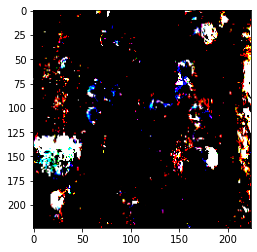

In [10]:
x,img=get_image("/content/muestras/test/a16-AceiteMario/SingleShot0085.jpg")
result=resize_and_rescale(img[0])
plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


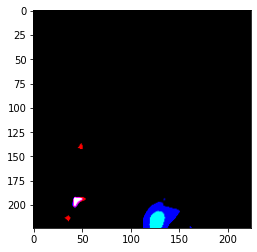

In [11]:
plt.imshow(result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


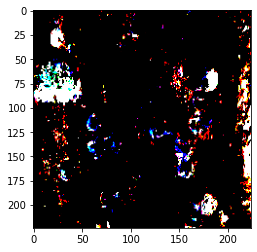

In [12]:
result_rot90 = tf.image.rot90(img[0])
result_flip_left_right=tf.image.flip_left_right(img[0])
result_flip_up_down=tf.image.flip_up_down(img[0])
plt.imshow(result_flip_up_down)

In [13]:
result == img[0]

<tf.Tensor: shape=(224, 224, 3), dtype=bool, numpy=
array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, Fa

# Data Generator

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
transformation_ratio = 0.05
train_path = "muestras/train"
test_path = "muestras/test"
datagen = ImageDataGenerator(rescale=1. / 255,
                             validation_split = 0.2,
                             rotation_range=transformation_ratio,
                             shear_range=transformation_ratio,
                             zoom_range=transformation_ratio,
                             cval=transformation_ratio,
                             horizontal_flip=True,
                             vertical_flip=True)

train_it = datagen.flow_from_directory(train_path, 
                                       target_size=(224,224), 
                                       color_mode='rgb', 
                                       class_mode="categorical",
                                       batch_size=25, #12
                                       subset = "training")

valid_it = datagen.flow_from_directory(train_path,
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=25,#12
                                     subset='validation')

datagen_test = ImageDataGenerator(rescale=1./255, rotation_range=transformation_ratio,
                             shear_range=transformation_ratio,
                             zoom_range=transformation_ratio,
                             cval=transformation_ratio,
                             horizontal_flip=True,
                             vertical_flip=True)

val_data = datagen_test.flow_from_directory(test_path, 
                                           target_size=(224, 224), 
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           shuffle=False)

Found 1923 images belonging to 19 classes.
Found 475 images belonging to 19 classes.
Found 284 images belonging to 19 classes.


In [15]:
num_classes=train_it.num_classes
input_shape=(224,224,3)
labels = train_it.class_indices.keys()
labels

dict_keys(['Achapo', 'Cedro-costenio', 'Chanul', 'Cipres', 'Cuangare', 'Eucalipto-blanco', 'Guayacan-amarillo', 'Nogal-cafetero', 'Pino-patula', 'Urapan', 'a16-AceiteMario', 'a21-Palialte-Amarillo', 'aguamanil-c716', 'c715-tangare', 'c717', 'd543', 'd574-cargadero', 'd575-caimito', 'n33-pomo'])

In [16]:
# summary
print("finished loading %d images from %d categories"%(((train_it.samples)+ (valid_it.samples)+ (val_data.samples)), num_classes))
print("train / validation / test split: %d, %d, %d"%((train_it.samples), (valid_it.samples), (val_data.samples)))

finished loading 2682 images from 19 categories
train / validation / test split: 1923, 475, 284


# Optimizator

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

# First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

The network we will construct contains 4 alternating convolutional and max-pooling layers, followed by a [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) after every other conv/pooling pair. After the last pooling layer, we will attach a fully-connected layer with 256 neurons, another dropout layer, then finally a softmax classification layer for our classes.

Our loss function will be, as usual, categorical cross-entropy loss, and our learning algorithm will be [AdaDelta](https://arxiv.org/abs/1212.5701). Various things about this network can be changed to get better performance, perhaps using a larger network or a different optimizer will help, but for the purposes of this notebook, the goal is to just get an understanding of an approximate baseline for comparison's sake, and so it isn't neccessary to spend much time trying to optimize this network.

Upon compiling the network, let's run `model.summary()` to get a snapshot of its layers.

In [18]:
# build the network
model = Sequential()
print("Input dimensions: ",(224, 224, 3))

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.34))#0.25

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.34))#0.25

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.4))#0.5

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()


Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                 

We've created a medium-sized network with ~1.2 million weights and biases (the parameters). Most of them are leading into the one pre-softmax fully-connected layer "dense_5".

We can now go ahead and train our model for 100 epochs with a batch size of 128. We'll also record its history so we can plot the loss over time later. 

In [ ]:
inicio = time.time()
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=opt, # sgdm
              metrics=['accuracy'])  # ver si se puede poner otra metrica adicional o solo recibe 1.

history = model.fit(train_it,
                    batch_size=32,#128, #32
                    epochs=60,#10
                    validation_data=valid_it,
                    steps_per_epoch=train_it.samples/train_it.batch_size,
                    validation_steps=valid_it.samples/valid_it.batch_size,
                  )
fin = time.time()
history
print("Fin",fin-inicio)

Epoch 1/60
76/76 [==============================] - 148s 2s/step - loss: 3.2625 - accuracy: 0.1123 - val_loss: 2.8447 - val_accuracy: 0.1200
Epoch 2/60
76/76 [==============================] - 146s 2s/step - loss: 2.8556 - accuracy: 0.1180 - val_loss: 2.8434 - val_accuracy: 0.1200
Epoch 3/60
76/76 [==============================] - 146s 2s/step - loss: 2.8525 - accuracy: 0.1170 - val_loss: 2.8441 - val_accuracy: 0.1200
Epoch 4/60
76/76 [==============================] - 145s 2s/step - loss: 2.8585 - accuracy: 0.1097 - val_loss: 2.8435 - val_accuracy: 0.1200
Epoch 5/60
76/76 [==============================] - 145s 2s/step - loss: 2.8535 - accuracy: 0.1144 - val_loss: 2.8500 - val_accuracy: 0.1200
Epoch 6/60
76/76 [==============================] - 144s 2s/step - loss: 2.8505 - accuracy: 0.1196 - val_loss: 2.8417 - val_accuracy: 0.1200
Epoch 7/60
76/76 [==============================] - 144s 2s/step - loss: 2.8496 - accuracy: 0.1186 - val_loss: 2.8413 - val_accuracy: 0.1200
Epoch 8/60
76

Let's plot the validation loss and validation accuracy over time.

In [ ]:
# history.history
# fig = plt.figure(figsize=(16,4))
fig,ax=plt.subplots(1,3)
# ax = fig.add_subplot(121)
ax[0].plot(history.history["val_loss"])
ax[0].set_title("validation loss")
ax[0].set_xlabel("epochs")

# ax2 = fig.add_subplot(122)
ax[1].plot(history.history["loss"])
ax[1].set_title("Train loss")
# ax[1].set_ylim(0, 1)
ax[1].set_xlabel("epochs")


# ax3 = fig.add_subplot(224)
ax[2].plot(history.history["accuracy"])
ax[2].set_title("Train accuracy")
ax[2].set_xlabel("epochs")
# ax3.set_ylim(0, 1)
plt.rcParams["figure.figsize"] = (16,4)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
# ax.plot(history2.history["val_loss"])
# ax.plot(history3.history["val_loss"])
ax.plot(history.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")
plt.legend(['val_loss','loss'])

ax2 = fig.add_subplot(122)
ax2.plot(history.history["accuracy"])
# ax2.plot(history2.history["val_accuracy"])
# ax2.plot(history3.history["val_accuracy"])
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['accuracy','val_accuracy'])
ax2.set_ylim(0, 1)

Notice that the validation loss begins to actually rise after around 16 epochs, even though validation accuracy remains roughly between 40% and 50%. This suggests our model begins overfitting around then, and best performance would have been achieved if we had stopped early around then. Nevertheless, our accuracy would not have likely been above 50%, and probably lower down.

We can also get a final evaluation by running our model on the training set. Doing so, we get the following results:

In [ ]:
loss, accuracy = model.evaluate(val_data, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
row=[["cnn",accuracy,loss,(fin-inicio)/60]]
stats = pd.DataFrame(row,columns=["model","test_accuracy","test_loss","tiempo_ejecucion(min)"])
stats

In [ ]:
probabilities = model.predict(val_data)
cm=confusion_matrix(val_data.classes,probabilities.argmax(axis=1))
sns.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,cmap='Blues')

In [ ]:
img, x = get_image('/content/SingleShot0103.jpg')
x=x.astype('float32') / 255.
probabilities_x = model.predict([x])
df = pd.DataFrame(probabilities_x,columns=train_it.class_indices.keys())
df

# MobileNet

In [ ]:
# import tensorflow as tf

mobileNet=tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobileNet.trainable = False
print("Number of layers in the base model: ", len(mobileNet.layers))

In [ ]:
mobileNet_model = Sequential()
mobileNet_model.add(mobileNet)
mobileNet_model.add(GlobalAveragePooling2D())
mobileNet_model.add(Dense(512, activation='relu'))
mobileNet_model.add(Dense(num_classes, activation="softmax"))
mobileNet_model.compile(loss="categorical_crossentropy", optimizer=opt,
                    metrics=["accuracy"])
len(mobileNet_model.trainable_variables)

In [ ]:
print("Number of layers in the base model: ", len(mobileNet.layers))
mobileNet.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobileNet.layers[:fine_tune_at]:
  layer.trainable = False
len(mobileNet_model.trainable_variables)

In [ ]:
inicio = time.time()
history4 = mobileNet_model.fit(train_it, 
                         batch_size=32,#45, 32
                         epochs=60,#10 
                         validation_data=valid_it)
fin = time.time()
print(fin-inicio)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history4.history["val_loss"])
# ax.plot(history2.history["val_loss"])
# ax.plot(history3.history["val_loss"])
ax.plot(history4.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")
plt.legend(['val_loss','loss'])

ax2 = fig.add_subplot(122)
ax2.plot(history4.history["accuracy"])
# ax2.plot(history2.history["val_accuracy"])
# ax2.plot(history3.history["val_accuracy"])
ax2.plot(history4.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['accuracy','val_accuracy'])
ax2.set_ylim(0, 1)

In [ ]:
loss, accuracy= mobileNet_model.evaluate(val_data, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
probabilities = mobileNet_model.predict(val_data)
df = pd.DataFrame(probabilities,columns=train_it.class_indices.keys())
#df
cm=confusion_matrix(val_data.classes,probabilities.argmax(axis=1))

sns.heatmap(cm, annot=True,xticklabels=train_it.class_indices.keys(),yticklabels=train_it.class_indices.keys(),cmap='Blues')

In [ ]:
img, x = get_image('/content/SingleShot0103.jpg')
x=x.astype('float32') / 255.
probabilities_x = mobileNet_model.predict([x])
df = pd.DataFrame(probabilities_x,columns=train_it.class_indices.keys())
df

In [ ]:
row=["MobileNet",accuracy,loss,(fin-inicio)/60]
stats.loc[1]= row
stats

# Vgg16

In [ ]:
# import tensorflow as tf
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

In [ ]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [ ]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model_new.summary()

In [ ]:
inicio = time.time()
history2 = model_new.fit(train_it, 
                         batch_size=125,#45, 32
                         epochs=60,#10 
                         validation_data=valid_it)
fin = time.time()
print(fin-inicio)

Our validation accuracy hovers close to 80% towards the end, which is more than 30% improvement on the original network trained from scratch (meaning that we make the wrong prediction on 20% of samples, rather than 50%). 

It's worth noting also that this network actually trains _slightly faster_ than the original network, despite having more than 100 times as many parameters! This is because freezing the weights negates the need to backpropagate through all those layers, saving us on runtime.

Let's plot the validation loss and accuracy again, this time comparing the original model trained from scratch (in blue) and the new transfer-learned model in green.

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
# ax.plot(history2.history["val_loss"])
# ax.plot(history3.history["val_loss"])
ax.plot(history2.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")
plt.legend(['val_loss','loss'])

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["accuracy"])
# ax2.plot(history2.history["val_accuracy"])
# ax2.plot(history3.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['accuracy','val_accuracy'])
ax2.set_ylim(0, 1)

Notice that whereas the original model began overfitting around epoch 16, the new model continued to slowly decrease its loss over time, and likely would have improved its accuracy slightly with more iterations. The new model made it to roughly 80% top-1 accuracy (in the validation set) and continued to improve slowly through 100 epochs.

It's possibly we could have improved the original model with better regularization or more dropout, but we surely would not have made up the >30% improvement in accuracy. 

Again, we do a final validation on the test set.

In [ ]:
loss, accuracy= model_new.evaluate(val_data, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)
# print("test recall",recall)
# print('test precision',Precision)

In [ ]:
row=["VGG16",accuracy,loss,(fin-inicio)/60]
stats.loc[2]= row
stats

To predict a new image, simply run the following code to get the probabilities for each class.

In [ ]:
# img, x = get_image('3.jpg')
# print(x_test)
probabilities = model_new.predict(val_data)
df = pd.DataFrame(probabilities,columns=labels)
#df
cm=confusion_matrix(val_data.classes,probabilities.argmax(axis=1))

sns.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,cmap='Blues')

In [ ]:
img, x = get_image('/content/SingleShot0103.jpg')
x=x.astype('float32') / 255.
probabilities_x = model_new.predict([x])
df = pd.DataFrame(probabilities_x,columns=labels)
df

# ResNet 50

In [ ]:
pretrained_model= tf.keras.applications.ResNet50V2(input_shape=input_shape, weights='imagenet',include_top=False)
pretrained_model.trainable = False
print("Number of layers in the base model: ", len(pretrained_model.layers))

In [ ]:
resnet_model = Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(GlobalAveragePooling2D())
# resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(num_classes, activation='softmax'))
resnet_model.summary()

In [ ]:
lr=random.choice((1e-2, 1e-3, 1e-4, 1e-5))
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=opt,
              # optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              # optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'],)
lr,len(resnet_model.trainable_variables)


In [ ]:
print("Number of layers in the base model: ", len(pretrained_model.layers))
pretrained_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 130

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
  layer.trainable = False
len(resnet_model.trainable_variables)

In [ ]:
inicio = time.time()
history2 = resnet_model.fit(train_it, 
                         batch_size=32,#45, 32
                         epochs=60,#10 
                         validation_data=valid_it)
fin = time.time()
print(fin-inicio)

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.plot(history2.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")
plt.legend(['val_loss', 'loss'])

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['accuracy', 'val_accuracy'])
ax2.set_ylim(0, 1)

In [ ]:
loss, accuracy= resnet_model.evaluate(val_data, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [ ]:
row=["ResNet50",accuracy,loss,(fin-inicio)/60]
stats.loc[3]= row
stats

In [ ]:
stats["Optimizer"] = opt.lr.numpy()
stats

In [ ]:
stats.to_csv("/content/stats.csv")

In [ ]:
# img, x = get_image('3.jpg')
# print(x_test)
probabilities = resnet_model.predict(val_data)
df = pd.DataFrame(probabilities,columns=labels)
#df
cm=confusion_matrix(val_data.classes,probabilities.argmax(axis=1))

sns.heatmap(cm, annot=True,xticklabels=labels,yticklabels=labels,cmap='Blues')

In [ ]:
img, x = get_image('/content/SingleShot0103.jpg')
x=x.astype('float32') / 255.
probabilities_x = resnet_model.predict([x])
df = pd.DataFrame(probabilities_x,columns=labels)
df

In [ ]:
# resnet_model.save("model_resnet_06022022.h5")
# model_new.save_weights('weights_resnet')

# EfficientNet


In [ ]:
base_model =  tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights = 'imagenet', include_top = False, input_shape=input_shape)
# Adding a global spatial average pooling layer
base_model.trainable = False
# x = base_model.output
# x = GlobalAveragePooling2D()(x)

# #Adding a fully-connected dense layer
# x = Dense(512, activation='relu')(x)
# predictions = Dense(num_classes, activation="softmax")(x)#.layers[-2].output
# efn_model = Model(inputs = base_model.input, outputs = predictions)
# # efn_model.summary()
# len(efn_model.trainable_variables)

24289280/24274472 [==============================] - 1s 0us/step


In [ ]:
efficientNet_model = Sequential()
efficientNet_model.add(base_model)
efficientNet_model.add(GlobalAveragePooling2D())
efficientNet_model.add(Dense(512, activation='relu'))
efficientNet_model.add(Dense(num_classes, activation="softmax"))
efficientNet_model.compile(loss="categorical_crossentropy", optimizer="adam",
                    metrics=["accuracy"])
len(efficientNet_model.trainable_variables)

4

In [ ]:
lr=random.choice((1e-2, 1e-3, 1e-4, 1e-5))
efficientNet_model.compile(loss="categorical_crossentropy", optimizer="adam",
                    metrics=["accuracy"])
lr

0.0001

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 177

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
len(efficientNet_model.trainable_variables)

Number of layers in the base model:  255


77

In [ ]:
inicio = time.time()
history3 = efficientNet_model.fit(train_it, 
                         batch_size=32,#45, 32
                         epochs=60,#10 
                         validation_data=valid_it)
fin = time.time()
print(fin-inicio)

Epoch 1/60
85/85 [==============================] - 35s 322ms/step - loss: 2.6968 - accuracy: 0.0813 - val_loss: 2.6393 - val_accuracy: 0.1440
Epoch 2/60
85/85 [==============================] - 25s 293ms/step - loss: 2.6407 - accuracy: 0.0793 - val_loss: 2.6317 - val_accuracy: 0.0800
Epoch 3/60
85/85 [==============================] - 24s 283ms/step - loss: 2.6340 - accuracy: 0.0852 - val_loss: 2.6283 - val_accuracy: 0.0800
Epoch 4/60
85/85 [==============================] - 24s 284ms/step - loss: 2.6241 - accuracy: 0.0793 - val_loss: 2.6277 - val_accuracy: 0.0800
Epoch 5/60
85/85 [==============================] - 24s 284ms/step - loss: 2.6171 - accuracy: 0.0882 - val_loss: 2.6025 - val_accuracy: 0.0800
Epoch 6/60
85/85 [==============================] - 24s 281ms/step - loss: 2.6013 - accuracy: 0.0852 - val_loss: 2.5930 - val_accuracy: 0.0800
Epoch 7/60
24/85 [=======>......................] - ETA: 13s - loss: 2.5966 - accuracy: 0.0722

(0.0, 1.0)

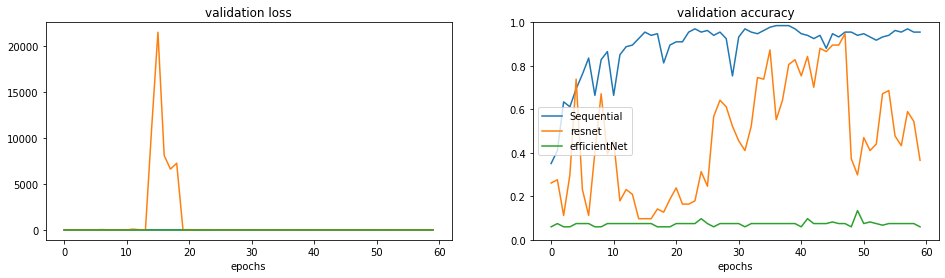

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.plot(history3.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.plot(history3.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
plt.legend(['Sequential', 'resnet',"efficientNet"])
ax2.set_ylim(0, 1)

In [ ]:
loss, accuracy= efficientNet_model.evaluate(val_data, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 28.45322608947754
Test accuracy: 0.11194030195474625
